## Data Preprocessing
### Data Loading

In [1]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

reviews = pd.read_csv(
    'dataset\Watches.tsv',
    sep='\t',
    error_bad_lines=False,
    warn_bad_lines=False)
reviews.head(3)

C:\Users\jyc02\AppData\Local\Temp\ipykernel_640\954002555.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews = pd.read_csv(
C:\Users\jyc02\AppData\Local\Temp\ipykernel_640\954002555.py:7: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews = pd.read_csv(


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31


Theres are 15 columns in the data. Amazon details what each columns containes, which I've included below:

- marketplace - 2 letter country code of the marketplace where the review was written.
- customer_id - Random identifier that can be used to aggregate reviews written by a single author.
- review_id - The unique ID of the review.
- product_id - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
- product_parent - Random identifier that can be used to aggregate reviews for the same product.
- product_title - Title of the product.
- product_category - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).
- star_rating - The 1-5 star rating of the review.
- helpful_votes - Number of helpful votes.
- total_votes - Number of total votes the review received.
- vine - Review was written as part of the Vine program.
- verified_purchase - The review is on a verified purchase.
- review_headline - The title of the review.
- review_body - The review text.
- review_date - The date the review was written.

In [2]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960204 entries, 0 to 960203
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   marketplace        960204 non-null  object
 1   customer_id        960204 non-null  int64 
 2   review_id          960204 non-null  object
 3   product_id         960204 non-null  object
 4   product_parent     960204 non-null  int64 
 5   product_title      960202 non-null  object
 6   product_category   960204 non-null  object
 7   star_rating        960204 non-null  int64 
 8   helpful_votes      960204 non-null  int64 
 9   total_votes        960204 non-null  int64 
 10  vine               960204 non-null  object
 11  verified_purchase  960204 non-null  object
 12  review_headline    960197 non-null  object
 13  review_body        960056 non-null  object
 14  review_date        960200 non-null  object
dtypes: int64(5), object(10)
memory usage: 109.9+ MB


### Removing Duplicates

With our first glimpse, the data provided by AWS is quite clean. Now we need to consider these problems:
- Whether there exists duplicated data
- Whether there exists NAs, causing missing-value problem

We could observe from above that null data do exist. However, the NA part is all contained in the concrete customer review contents, which would not be a problem for our analysis, as our main target in the later stage would be forming the embeddings for items and users. So the only assignment would be processing the duplicated data.

In [3]:
sum(reviews.review_id.duplicated())

0

The `review_id` has no duplicated items. However, we could not guarantee that there aren't any duplicated reviews. Here we assume that if a customer sends more than one review on one single commodity, we view it as duplicated data in the dataset. 

This does not mean that one cannot post multiple reviews on one product (follow-up reviews are indeed quite common), we do this for the simplicity of our analysis and the formation of the embeddings; meanwhile, this could compress the scarcity for our future matrices.

Hence, if `customer_id` and `product_id` show up more than once, it's a duplicated review.

In [4]:
purchase_ids = ['customer_id', 'product_id']

duplicates = reviews[reviews.duplicated(subset=purchase_ids, keep=False)].sort_values(purchase_ids)
duplicates.head(4)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
180410,US,685318,R1J1TVEYBP3A7M,B003QG1SO2,47470030,Timex Men's Easy Reader Date Leather Strap Watch,Watches,3,0,1,N,Y,Three Stars,"it's ok, but there's one part below the the nu...",2015-03-10
227516,US,685318,R1DJUOOB0RFMRP,B003QG1SO2,47470030,Timex Men's Easy Reader Date Leather Strap Watch,Watches,4,0,0,N,Y,Four Stars,it's nice.,2015-02-01
45889,US,817344,R3R845UJQPL7DP,B004VW55NA,921527551,Women Geneva Rhinestone Leather Band Quartz Wr...,Watches,3,0,0,N,Y,Three Stars,nice & shiny,2015-07-20
46029,US,817344,R39DJJ1LM1K14N,B004VW55NA,921527551,Women Geneva Rhinestone Leather Band Quartz Wr...,Watches,3,0,0,N,Y,Three Stars,Nice,2015-07-20


So there are some reviews that are basically the same, but some people have updated their review by submitting a new one, which could be considered as the follow-up updates discussed above. It would make sense if I keep the most recent review here.

In [5]:
reviews = (reviews.sort_values(['customer_id', 'product_id', 'review_date'], ascending=[False, False, True])
        .drop_duplicates(subset=purchase_ids, keep='last'))

### Parent Product Analysis

First, we want to see the most-reviewed commodities and those that have been reviewed only once. We pick the first couple of the head and tail using `value_counts()` function.

In [6]:
reviews.product_title.value_counts().to_frame().head(5)
reviews.product_title.value_counts().to_frame().tail(5)

,product_title
SE JT6216 21-Piece Watch Repair Kit,4390
Timex Unisex Weekender Analog Quartz Watch,3222
Bling Jewelry Plated Classic Round CZ Ladies Watch,3046
Casio Men's Sport Analog Dive Watch,2047
Casio Women's LRW-200H-2BVCF Stainless Steel Watch Resin Band,2008


,product_title
PUMA Unisex PU910501003 Cardiac II Red Heart Rate Monitor Watch,1
GUESS Women's U0226L1 Alluring Rose-Print Watch,1
TKO ORLOGI Women's TK549-BBL Unisex Milano Remixed Blue Watch,1
Invicta Women's 80202 Pro Diver Mother-Of-Pearl Dial Gunmetal Ion-Plated Mesh Stainless Steel Watch,1
Extra Thick Padded Watch Band Genuine Leather Dark Brown 22 millimeters Tech Swiss,1


Next we want to explore the `product_parent` tag. The AWS just specifies it as "random identifier that can be used to aggregate reviews for the same product", which I view as ambiguous. I would expect that the "parent" would be the main product in an Amazon listing, and child products are those of different sizes, colors, editions, etc. I'm going to do some research and see whether my assumption holds.

In [7]:
remove = reviews[['product_parent', 'product_id']].drop_duplicates()
remove.product_parent.value_counts().head(5)

315669547    48
297568235    48
324241921    37
802598355    35
995353619    31
Name: product_parent, dtype: int64

<BarContainer object of 10 artists>

([<matplotlib.axis.XTick at 0x22f896f07f0>,
 [Text(0, 0, '315669547'),
  Text(1, 0, '297568235'),
  Text(2, 0, '324241921'),
  Text(3, 0, '802598355'),
  Text(4, 0, '995353619'),
  Text(5, 0, '605871703'),
  Text(6, 0, '716820658'),
  Text(7, 0, '31888262'),
  Text(8, 0, '716249689'),
  Text(9, 0, '544812143')])

Text(0.5, 0, 'parent_id')

Text(0, 0.5, 'number of children')

Text(0.5, 1.0, 'Number of products sharing the same parent (TOP 10)')

<Figure size 1500x800 with 0 Axes>

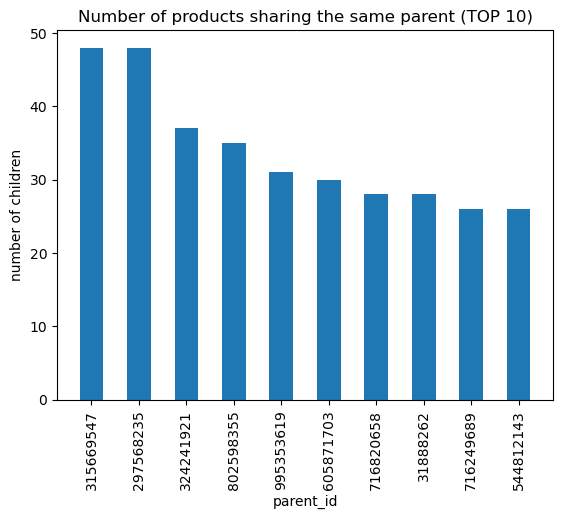

<Figure size 1500x800 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
parent_count = remove.product_parent.value_counts().to_frame().head(10)
labels = parent_count.index
dt = parent_count.product_parent
plt.bar(range(len(dt)), dt, width=0.5)
plt.xticks(range(len(dt)), labels, rotation=90)
plt.xlabel("parent_id")
plt.ylabel("number of children")
plt.title("Number of products sharing the same parent (TOP 10)")
plt.figure(figsize=(15,8))
plt.show()


In [9]:
parent_id = 315669547
reviews[reviews.product_parent == parent_id][['product_parent', 'product_id', 'product_title']].drop_duplicates().head()

,product_parent,product_id,product_title
502758,315669547,B00IE9H9RG,Interchangeable Military-style Nylon Watch Str...
505779,315669547,B00I8UJ3RK,Interchangeable Military-style Nylon Watch Str...
219237,315669547,B00I812VXC,Interchangeable Military-style Nylon Watch Str...
204222,315669547,B00I5RW8K0,Interchangeable Military-style Nylon Watch Str...
87673,315669547,B00I8UJ4GU,Interchangeable Military-style Nylon Watch Str...


In [10]:
reviews[reviews.product_parent == parent_id][['product_title']].drop_duplicates()

,product_title
502758,Interchangeable Military-style Nylon Watch Str...


From the above result we could see that `product_parent` distinguishes between different products since the `product_id`  tags are different. However, all of these products share the same value for `product_title`, which proves that our assumption was indeed correct.

This could cause a problem for our future research, as a user theoretically could be recommended with three products with unique `product_id`, but they're really all the same product, except probably different colors. If I want to recommend three various commodities, the result might not be ideal. In other words, the `product_id` is not a proper label for one certain commodity.

What I'm going to do is to modify the data in the `reviews` to make sure that there is only one `product_id` per `product_title`.

In [11]:
products = reviews[['product_id', 'product_title']].drop_duplicates(subset='product_title', keep='first')
cols = reviews.columns
reviews = reviews.drop('product_id', axis=1).merge(products, on='product_title')[cols]

reviews[['product_id', 'product_title']].drop_duplicates().product_title.value_counts().head(5)

Tommy Hilfiger Men's 1790926 Stainless Steel and Grosgrain Leather Strap Sport Watch                            1
Tissot PRC 200 Silver Chronograph Quartz Sport Men's watch #T055.417.11.037.00                                  1
Breda Men's 2369-setB "James" Pilot-Style faux leather Watch Set with Two Interchangeable faux leather Bands    1
Timex Classics Bracelet Silver-Tone Dial Women's Watch #T2N838                                                  1
Invicta Women's 12503 Pro Diver Silver Dial Watch                                                               1
Name: product_title, dtype: int64

Now the preliminary part has been done. We then check whether there are still multiple `product_id` values for one `product_parent` value.

544812143    23
86574288      9
193303569     9
286396053     7
459113922     7
Name: product_parent, dtype: int64

<BarContainer object of 10 artists>

([<matplotlib.axis.XTick at 0x22f80b1c7c0>,
 [Text(0, 0, '544812143'),
  Text(1, 0, '86574288'),
  Text(2, 0, '193303569'),
  Text(3, 0, '286396053'),
  Text(4, 0, '459113922'),
  Text(5, 0, '143267424'),
  Text(6, 0, '821569073'),
  Text(7, 0, '171453630'),
  Text(8, 0, '632649662'),
  Text(9, 0, '674800494')])

Text(0.5, 0, 'parent_id')

Text(0, 0.5, 'number of children')

Text(0.5, 1.0, 'Number of products sharing the same parent (TOP 10)')

<Figure size 1500x800 with 0 Axes>

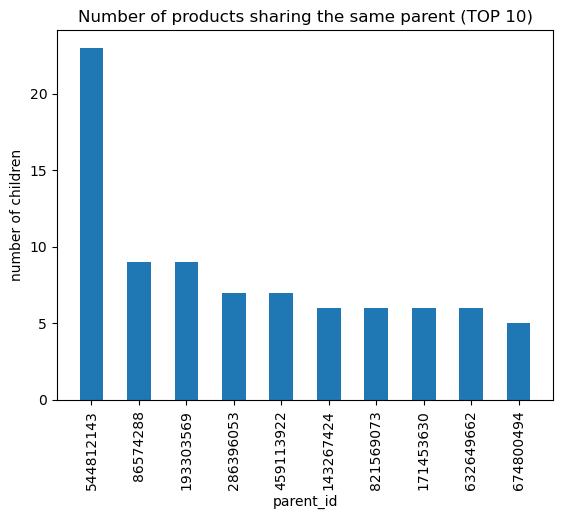

<Figure size 1500x800 with 0 Axes>

In [12]:
extracted = reviews[['product_parent', 'product_id']].drop_duplicates()
extracted.product_parent.value_counts().head(5)

parent_count = extracted.product_parent.value_counts().to_frame().head(10)
labels = parent_count.index
dt = parent_count.product_parent
plt.bar(range(len(dt)), dt, width=0.5)
plt.xticks(range(len(dt)), labels, rotation=90)
plt.xlabel("parent_id")
plt.ylabel("number of children")
plt.title("Number of products sharing the same parent (TOP 10)")
plt.figure(figsize=(15,8))
plt.show()

In [13]:
idx = 544812143
reviews[reviews.product_parent == idx][['product_title']].drop_duplicates().head()

,product_title
675555,Game Time Men's NFL Retro Series Watch - New O...
685904,Game Time Men's NFL Retro Series Watch - New E...
736537,Game Time Retro - NFL
796196,Game Time Men's NFL Retro Series Watch - Green...
799055,Game Time Men's NFL Retro Series Watch


## Visualizations

([<matplotlib.patches.Wedge at 0x22f818231f0>,
 [Text(1.0576066556234411, 0.3024370380442851, '★'),
  Text(0.8217267913116816, 0.7312763365791406, '★★'),
  Text(0.44305184105602774, 1.0068292139865949, '★★★'),
  Text(-0.4380815702643979, 1.0090017531177433, '★★★★'),
  Text(-0.3229112043495149, -1.051536187729907, '★★★★★')],
 [Text(0.576876357612786, 0.1649656571150646, '8.9%'),
  Text(0.44821461344273533, 0.39887800177044025, '5.4%'),
  Text(0.2416646405760151, 0.5491795712654154, '8.2%'),
  Text(-0.23895358378058065, 0.5503645926096782, '18.0%'),
  Text(-0.1761333841906445, -0.5735651933072219, '59.5%')])

Text(0.5, 1.0, 'Distribution of star ratings')

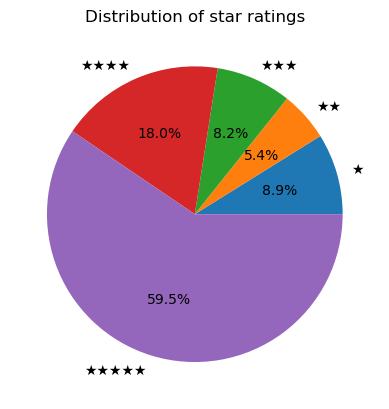

In [14]:
ratings = reviews.star_rating.value_counts().to_frame()
ratings = ratings.sort_index()
normalized_rating = ratings.star_rating/ratings.star_rating.sum(axis=0)
labels = ["★", "★★", "★★★", "★★★★", "★★★★★"]
plt.pie(normalized_rating, autopct='%.1f%%', labels=labels)
plt.title("Distribution of star ratings")
plt.show()

<BarContainer object of 11 artists>

([<matplotlib.axis.XTick at 0x22fa52e2050>,
 [Text(0, 0, '2001-2004'),
  Text(1, 0, '2005-2006'),
  Text(2, 0, '2007'),
  Text(3, 0, '2008'),
  Text(4, 0, '2009'),
  Text(5, 0, '2010'),
  Text(6, 0, '2011'),
  Text(7, 0, '2012'),
  Text(8, 0, '2013'),
  Text(9, 0, '2014'),
  Text(10, 0, '2015')])

Text(0.5, 0, 'timeline')

Text(0, 0.5, 'Number of reviews')

Text(0.5, 1.0, 'Number of reviews through time')

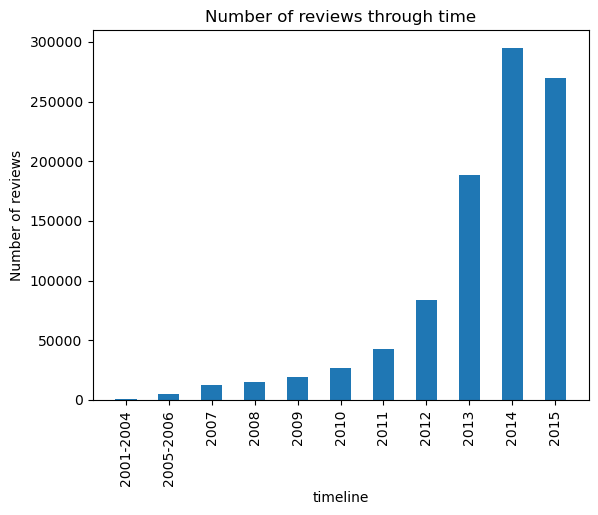

In [36]:
dates = pd.to_datetime(reviews.review_date)
years = dates.dt.strftime('%Y')
time_track = years.value_counts().to_frame().sort_index()
time_track.loc['2001-2004'] = time_track.loc['2001'] + time_track.loc['2002'] + time_track.loc['2003'] + time_track.loc['2004']
time_track.loc['2005-2006'] = time_track.loc['2005'] + time_track.loc['2006']
time_track.drop(['2001', '2002', '2003', '2004', '2005', '2006'], axis=0, inplace=True)
time_track = time_track.sort_index()

labels = time_track.index
dt = time_track.review_date
plt.bar(range(len(dt)), dt, width=0.5)
plt.xticks(range(len(dt)), labels, rotation=90)
plt.xlabel("timeline")
plt.ylabel("Number of reviews")
plt.title("Number of reviews through time")
plt.show()


We did some exploration to dig into these products with different `product_title`, and found that these watches are simply different products, with the difference more than just color and size. For instance, the above listed five products are watches in collaboration with different NFL teams. We definitely should view these as different products. Hence, our purpose has been reached.

In [ ]:
reviews.to_csv('preprocessed.csv')